In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import xgboost as xgb
seed=10

In [2]:
data = pd.read_csv('Corona_NLP.csv')
data.head(),data.shape

(   UserName  ScreenName   Location     TweetAt  \
 0      3799       48751     London  16-03-2020   
 1      3800       48752         UK  16-03-2020   
 2      3801       48753  Vagabonds  16-03-2020   
 3      3802       48754        NaN  16-03-2020   
 4      3803       48755        NaN  16-03-2020   
 
                                        OriginalTweet           Sentiment  
 0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
 1  advice Talk to your neighbours family to excha...            Positive  
 2  Coronavirus Australia: Woolworths to give elde...            Positive  
 3  My food stock is not the only one which is emp...            Positive  
 4  Me, ready to go at supermarket during the #COV...  Extremely Negative  ,
 (41157, 6))

In [3]:
data = data.iloc[:10000,-2:]
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Checking for missing values

In [4]:
data.isnull().any()

OriginalTweet    False
Sentiment        False
dtype: bool

### No missing data

In [5]:
data.columns = data.columns.str.lower()
data['sentiment'] = data['sentiment'].replace({
    'Extremely Negative':'negative',
    'Negative':'negative',
    'Neutral':'neutral',
    'Extremely Positive':'positive',
    'Positive':'positive'
})

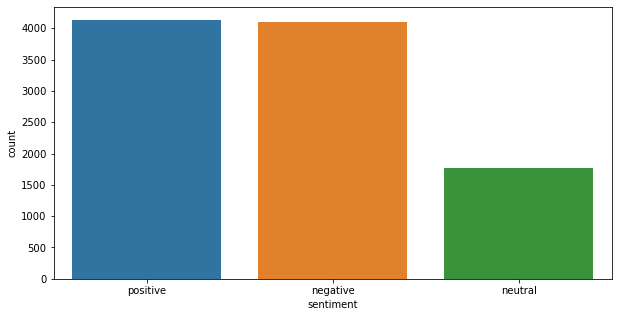

In [6]:
fig = plt.figure(figsize = (10, 5))
sns.countplot(x = data.sentiment, order = data.sentiment.value_counts().index);

In [7]:
data

,originaltweet,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,advice Talk to your neighbours family to excha...,positive
2,Coronavirus Australia: Woolworths to give elde...,positive
3,My food stock is not the only one which is emp...,positive
4,"Me, ready to go at supermarket during the #COV...",negative
...,...,...
9995,"Popped out for food in #oldham \r\r\nPolite , ...",positive
9996,Found my first paper towel in weeks at a super...,positive
9997,"Through the #Coronavirus chaos, Im grateful f...",negative
9998,"Therapist, Lisa Olivera gave gratitude cards t...",positive


In [8]:
# creating functions for text processing

string.punctuation
def final(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full['originaltweet'][i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full['originaltweet'][i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full['originaltweet'][i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full['originaltweet'][i])
        X_data_full_lemmatized_words.append(test_data)
        
    # creating the bag of words model
    cv = CountVectorizer(max_features=10000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()
    
    
    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()
    
#     return X_data_full_tfidf
    return X_data_full_vector

In [9]:
X = final(data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, data.sentiment, test_size=.2, random_state=seed)

## Model Selection

### Multinomial Naive Bayes

In [11]:
# Instantiating, fitting and predicting

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predictions = MNB.predict(X_test)

In [12]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

    negative       0.66      0.74      0.70       792
     neutral       0.57      0.41      0.47       375
    positive       0.67      0.69      0.68       833

    accuracy                           0.65      2000
   macro avg       0.63      0.61      0.62      2000
weighted avg       0.65      0.65      0.65      2000

[[584  40 168]
 [110 152 113]
 [185  75 573]]
Accuracy :  65.45  %
f1_score :  0.649


### XGBoost

In [13]:
# Instatiation, fitting and predictions

xgb_ = xgb.XGBClassifier()
xgb_.fit(X_train, y_train)
predictions = xgb_.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
# Model evaluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

xgb_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
xgb_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , xgb_accuracy , " %")
print("f1_score : " , xgb_f1)

              precision    recall  f1-score   support

    negative       0.78      0.75      0.76       792
     neutral       0.62      0.64      0.63       375
    positive       0.75      0.77      0.76       833

    accuracy                           0.74      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.74      0.74      0.74      2000

[[596  70 126]
 [ 54 239  82]
 [119  75 639]]
Accuracy :  73.7  %
f1_score :  0.737


### Random Forest

In [15]:
# Instatiation, fitting and predictions

from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [16]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

    negative       0.57      0.74      0.64       792
     neutral       0.59      0.42      0.49       375
    positive       0.64      0.54      0.59       833

    accuracy                           0.60      2000
   macro avg       0.60      0.57      0.57      2000
weighted avg       0.60      0.60      0.59      2000

[[584  38 170]
 [135 159  81]
 [309  72 452]]
Accuracy :  59.75  %
f1_score :  0.592


In [ ]:
#Comapring the accuracy for various models

model = ['MNB', 'Random Forest', 'XGBoost']
acc = [MNB_accuracy, rfc_accuracy, xgb_accuracy]

sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Test Accuracy %")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model, y= acc)
plt.show()

In [ ]:
# Comparing the f1-score for various models
model = ['MNB', 'Random Forest', 'XGBoost']
f1_score = [MNB_f1, rfc_f1, xgb_f1]

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
plt.yticks(np.linspace(0,1,21))
plt.ylabel("f1-score")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model,  y= f1_score)
plt.show()